<h1><b><center>CLASIFICACIÓN DE NORMALIDAD EN TEJIDO DE MAMAS A PARTIR DE IMÁGENES DIGITALES DE RAYOS X</center></h1>

|<h2><font color='white'>-----------------------</font><b>DIEGO FERNANDO VELASCO GIRALDO||
|---|---|
|||
|||
| <left><font size="4">Estudiante de Maestría en Ingeniería con Énfasis en Ingeniería Electrónica</font> | <center><img src="https://drive.google.com/uc?id=1CtdK5Litx2pQmTGD3U2Qs0MxIVs_nB8H" width="55" height="80" /> |
|||
| <left><font size="4">Grupo de Investigación Percepción y Sistemas Inteligentes - Univalle</font> | <center><img src="https://drive.google.com/uc?id=1qEQd1k3SOIeLx-X0OSYQ0DosajsIy9Vc" width="165" height="70" /> |
|||
| <left><i><font size="4">Correo Electrónico: diego.fernando.velasco@correounivalle.edu.co</font></i> | <center><i><font size="4">Celular: 3234777477</font></i> |
|||

<center><h4><i>Proyecto de Grado - Modalidad: Profundización - Universidad del Valle - Director: Humberto Loaiza, Ph.D.</i></h4>
<br>

In [ ]:
# import the necessary packages
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import argparse
import cv2
import glob
import os
import shutil
from pandas import DataFrame
import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from skimage.feature import local_binary_pattern
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Implementación Proyecto Grado Maestría

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Implementación Proyecto Grado Maestría


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
dataPath = "all-mias"

nn_svm_folder = '/nn_svm'

dataPath01 = dataPath + nn_svm_folder

if os.path.isdir(dataPath01) is False:
  os.mkdir(dataPath01)

textFile = os.path.join(dataPath,"miasInfo.txt")
mias_df = pd.read_csv(textFile, sep=" ", header=0)
mias_df.head()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0


In [ ]:
values = {"SEVERITY": 'N', "X": 0, "Y": 0, "RADIUS": 0}
mias_df = mias_df.fillna(value=values)

In [ ]:
mias_df.X = mias_df.X.astype(int)
mias_df.Y = mias_df.Y.astype(int)
mias_df.RADIUS = mias_df.RADIUS.astype(int)
#mias_df.head()
print(mias_df)

NameError: ignored

In [ ]:
mias_df.loc[mias_df["SEVERITY"] !='N', "SEVERITY"] = 'A'
display(mias_df)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,A,535,425,197
1,mdb002,G,CIRC,A,522,280,69
2,mdb003,D,NORM,N,0,0,0
3,mdb004,D,NORM,N,0,0,0
4,mdb005,F,CIRC,A,477,133,30
...,...,...,...,...,...,...,...
325,mdb318,D,NORM,N,0,0,0
326,mdb319,D,NORM,N,0,0,0
327,mdb320,D,NORM,N,0,0,0
328,mdb321,D,NORM,N,0,0,0


In [ ]:
#Drop a las anormales que no están marcadas por experto:

#mias_df_new = mias_df.drop(mias_df[(mias_df['SEVERITY'] == 'A') & (mias_df['RADIUS'] == 0)].index) #Esta parte la quitaré, me afecta para la hora de predecir X, Y
#display(mias_df_new)                                                                               #con la U-Net, ahora supondré que la SEVERITY está bien etiquetada.
mias_df_new = mias_df
#print("\nLabeled abnormalities (more than one in some images) and labeled as normal: ", mias_df_new.shape)

#Split by class:
abnormalClass = mias_df_new[mias_df_new.SEVERITY=='A']
print("Labeled as abnormal: ", abnormalClass.shape)
normalClass = mias_df_new[mias_df_new.SEVERITY=='N']
print("Labeled as normal: ", normalClass.shape)

#Unique REFNUM:
mias_df_uniques = mias_df_new.drop_duplicates(subset = ["REFNUM"]) #REFNUM únicos porque se repiten para número de imgs no de anormalidades presentes
abnormal_uniques = mias_df_uniques[mias_df_uniques.SEVERITY=='A']
normal_uniques = mias_df_uniques[mias_df_uniques.SEVERITY=='N']
print("\nNumber of images: ", mias_df_uniques.shape)
print("Number of abnormal images: ", abnormal_uniques.shape)
print("Number of normal images: ", normal_uniques.shape)

Labeled as abnormal:  (121, 7)
Labeled as normal:  (209, 7)

Number of images:  (322, 7)
Number of abnormal images:  (113, 7)
Number of normal images:  (209, 7)


In [ ]:
orig_path = dataPath+'/01_allmias_mat_proc_eq/'
#comp_name = '_processed.png'
comp_name = '_output.png'

abnormal_fileNames = abnormalClass.REFNUM
normal_fileNames = normalClass.REFNUM

abnormal_path = dataPath01+'/abnormal/'
normal_path = dataPath01+'/normal/'


if os.path.isdir(abnormal_path) is False:
    os.makedirs(abnormal_path)
    os.makedirs(normal_path)

    for image_name in abnormal_fileNames:
        #shutil.copy(dataPath+'/all-miasPythonProcessed/'+image_name+'_processed.png', benign_processed_path)
        shutil.copy(orig_path + image_name + comp_name, abnormal_path)

    for image_name in normal_fileNames:
        #shutil.copy(dataPath+'/all-miasPythonProcessed/'+image_name+'_processed.png', normal_processed_path)
        shutil.copy(orig_path + image_name + comp_name, normal_path)

# Data preparation / Preprocessing

In [ ]:
def getMammogramsHist(image):
    features = []
    hist = cv2.calcHist([image],[0],None,[251],[5,256])
    #features.extend(hist)
    features = hist
    return features

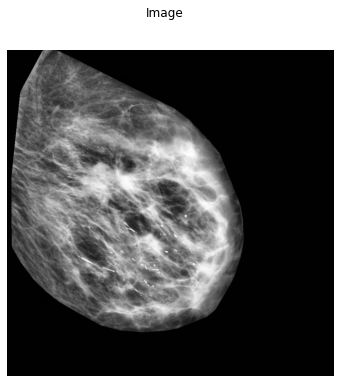

In [ ]:

# load the image and show it
image = cv2.imread(abnormal_path+'mdb148_output.png', 0)

#im_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Plot side by side the original and equalized image
#fig, axs = plt.subplots(2, 3, figsize=(9, 9), sharey=True)
fig, (ax1) = plt.subplots(1, 1, figsize=(6,6))
fig.suptitle('Image')
# Show image
plt.imshow(image, cmap='gray'), plt.axis("off")
plt.show()
#print(np.unique(image))

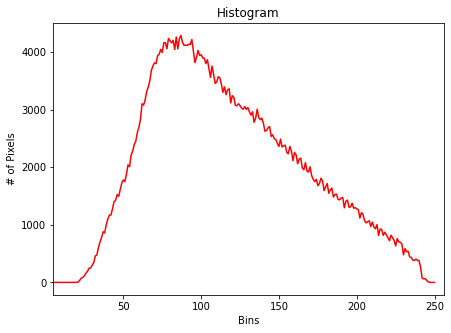

In [ ]:
hist = cv2.calcHist([image], [0], None, [251], [5, 256])

plt.figure(figsize=(7, 5))
plt.title("Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist, color = "r")
plt.xlim([5, 256])
plt.show()


In [ ]:
#from scipy.stats import mean
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import entropy

print('mean: ',np.mean(hist))
print('standard deviation: ',np.std(hist))
print('skewness: ',skew(hist))
print('kurtosis: ',kurtosis(hist))
print('entropy: ',entropy(hist))

data = [['mdb148', float(np.mean(hist)), float(np.std(hist)), float(skew(hist)), float(kurtosis(hist)), float(entropy(hist))]]
stats_df = pd.DataFrame(data, columns = ['img_name', 'mean', 'std_dev', 'skewness', 'kurtosis', 'entropy'])
display(stats_df)

mean:  1907.4104
standard deviation:  1362.4662
skewness:  [0.17763153]
kurtosis:  [-1.2310354]
entropy:  [5.215594]


,img_name,mean,std_dev,skewness,kurtosis,entropy
0,mdb148,1907.4104,1362.466187,0.177632,-1.231035,5.215594


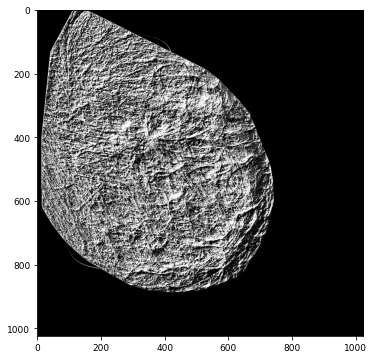

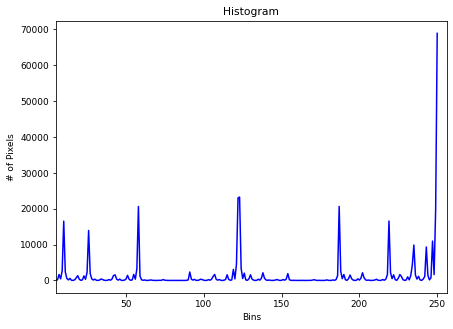

In [ ]:


# # settings for LBP

METHOD = 'default'
radius = 2 #Solo cambio este valor
n_points = 8 * radius
matplotlib.rcParams['font.size'] = 9


lbp = local_binary_pattern(image, n_points, radius, METHOD)
lbp = np.array(lbp, dtype=np.uint8)


#fig, ax = plt.subplots(figsize=(14,14))
plt.figure(figsize=(6, 6))
#plt.plot.set_title('LBP')
image_neg = cv2.bitwise_not(lbp)
plt.imshow(image_neg, cmap='gray')


#plt.subplot(1,2,2).set_title('Hist')

lbp_hist = cv2.calcHist([image_neg],[0],None,[251],[5,256])
plt.figure(figsize=(7, 5))
plt.title("Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(lbp_hist, color = "b")
plt.xlim([5, 256])
plt.show()

#lbp_hist = cv2.calcHist([image_neg],[0],None,[200],[5,256])
#plt.plot(lbp_hist, color = "b")



#plt.show()

In [ ]:
stats_df = stats_df.assign(lbp_mean=float(np.mean(lbp_hist)),
               lbp_std_dev=float(np.std(lbp_hist)),
               lbp_skewness=float(skew(lbp_hist)),
               lbp_kurtosis=float(kurtosis(lbp_hist)),
               lbp_entropy=float(entropy(lbp_hist)))


#stats_df = pd.DataFrame(data, columns = ['img_name', 'mean', 'std_dev', 'skewness', 'kurtosis', 'entropy'])
display(stats_df)

,img_name,mean,std_dev,skewness,kurtosis,entropy,lbp_mean,lbp_std_dev,lbp_skewness,lbp_kurtosis,lbp_entropy
0,mdb148,1907.4104,1362.466187,0.177632,-1.231035,5.215594,1515.227051,5609.617676,8.081864,83.935989,3.638278


In [ ]:
from skimage.feature import greycomatrix, greycoprops

def get_textural_features(img):
    #img = img_as_ubyte(rgb2gray(img))
    glcm = greycomatrix(img, [1], [0], 256, symmetric=True, normed=True)
    dissimilarity = greycoprops(glcm, 'dissimilarity')[0, 0]
    correlation = greycoprops(glcm, 'correlation')[0, 0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    feature = np.array([dissimilarity, correlation, homogeneity, energy])
    return feature

In [ ]:
images_path = dataPath+'/01_allmias_mat_proc_eq/'
images = glob.glob(images_path+'*.png')
images = sorted(images)
names = []
hists = []
#columns = ['REFNUM', 'SEVERITY', 'MEAN', 'STD_DEV', 'SKEWNESS', 'KURTOSIS', 'ENTROPY', 'LBP_MEAN', 'LBP_STD_DEV', 'LBP_SKEWNESS', 'LBP_KURTOSIS', 'LBP_ENTROPY']
#columns = ['REFNUM', 'SEVERITY', 'LBP_MEAN', 'LBP_STD_DEV', 'LBP_SKEWNESS', 'LBP_KURTOSIS', 'LBP_ENTROPY']
#columns = ['REFNUM', 'SEVERITY', 'DISSIMILARITY', 'CORRELATION', 'HOMOGENEITY', 'ENERGY']

#columns = ['REFNUM', 'SEVERITY', 'MEAN', 'STD_DEV', 'SKEWNESS', 'KURTOSIS', 'ENTROPY', 'LBP_MEAN', 'LBP_STD_DEV', 'LBP_SKEWNESS', 'LBP_KURTOSIS', 'LBP_ENTROPY',
#           'DISSIMILARITY', 'CORRELATION', 'HOMOGENEITY', 'ENERGY', 'LBP_DISSIMILARITY', 'LBP_CORRELATION', 'LBP_HOMOGENEITY', 'LBP_ENERGY']

columns = ['REFNUM', 'SEVERITY', 'HIST_MEAN', 'HIST_MEDIAN', 'HIST_ENTROPY', 'LBP_HIST_MEAN', 'LBP_HIST_MEDIAN', 'LBP_HIST_ENTROPY',
           'DISSIMILARITY', 'CORRELATION', 'HOMOGENEITY', 'ENERGY', 'LBP_DISSIMILARITY', 'LBP_CORRELATION', 'LBP_HOMOGENEITY', 'LBP_ENERGY']



stats_df = pd.DataFrame(columns = columns)
METHOD = 'default'
radius = 1 #Solo cambio este valor (1 el mejor hasta ahora)
n_points = 8 * radius
matplotlib.rcParams['font.size'] = 9

for image_path in images:
    image = cv2.imread(image_path, 0)
    hist = cv2.calcHist([image], [0], None, [251], [5, 256])
    lbp = local_binary_pattern(image, n_points, radius, METHOD)
    lbp = np.array(lbp, dtype=np.uint8)
    lbp_neg = cv2.bitwise_not(lbp)
    lbp_hist = cv2.calcHist([lbp_neg],[0],None,[251],[5,256])
    basename = os.path.basename(image_path)
    name = os.path.splitext(basename)[0]
    name = name[:6]
    df_1 = mias_df_new[mias_df_new['REFNUM'] == name]
    data_1 = df_1[['REFNUM', 'SEVERITY']].values.flatten().tolist()
    data_1 = [data_1[0], data_1[1]]
    #data_2 = [float(np.mean(hist)), float(np.std(hist)), float(skew(hist)), float(kurtosis(hist)), float(entropy(hist)),
    #          float(np.mean(lbp_hist)), float(np.std(lbp_hist)), float(skew(lbp_hist)), float(kurtosis(lbp_hist)), float(entropy(lbp_hist))]
    data_2 = [float(np.mean(hist)), float(np.median(hist)), float(entropy(hist)),
              float(np.mean(lbp_hist)), float(np.median(lbp_hist)), float(entropy(lbp_hist))]
    #data_2 = [float(np.mean(lbp_hist)), float(np.std(lbp_hist)), float(skew(lbp_hist)), float(kurtosis(lbp_hist)), float(entropy(lbp_hist))]
    data_3 = get_textural_features(image)
    data_4 = get_textural_features(lbp_neg)
    stats_data = [*data_1, *data_2, *data_3, *data_4]
    #print(stats_data)
    stats_df.loc[len(stats_df)] = stats_data

In [ ]:
stats_df.head()

,REFNUM,SEVERITY,HIST_MEAN,HIST_MEDIAN,HIST_ENTROPY,LBP_HIST_MEAN,LBP_HIST_MEDIAN,LBP_HIST_ENTROPY,DISSIMILARITY,CORRELATION,HOMOGENEITY,ENERGY,LBP_DISSIMILARITY,LBP_CORRELATION,LBP_HOMOGENEITY,LBP_ENERGY
0,mdb001,A,787.163330,918.0,5.316766,635.123535,76.0,3.730065,0.974382,0.997384,0.853324,0.800426,12.780742,0.783203,0.849583,0.813290
1,mdb002,A,821.358582,1010.0,5.330912,664.290833,83.0,3.736704,0.887952,0.998219,0.852686,0.795360,14.274293,0.745256,0.844505,0.807423
2,mdb003,N,733.661377,916.0,5.257604,584.741028,65.0,3.690689,0.792100,0.997781,0.869335,0.821332,11.637179,0.792411,0.862785,0.828015
3,mdb004,N,900.697205,1059.0,5.204337,720.139465,79.0,3.717852,1.034601,0.997554,0.835874,0.779695,14.958837,0.755345,0.831346,0.789987
4,mdb005,A,1577.270874,772.0,4.864488,1212.286865,190.0,3.889067,2.080559,0.994984,0.704251,0.613903,28.307208,0.715536,0.695057,0.637455


In [ ]:
'''
images_path = dataPath+'/01_allmias_mat_proc_eq/'
images = glob.glob(images_path+'*.png')
images = sorted(images)
stats_df = pd.DataFrame()
METHOD = 'default'
radius = 4
n_points = 8 * radius
matplotlib.rcParams['font.size'] = 9
hists = []
lbp_hists = []
texturals = []
texturals_lbp = []
labels = []
for image_path in images:
    image = cv2.imread(image_path, 0)
    hist = cv2.calcHist([image], [0], None, [251], [5, 256])
    #print(hist.shape)
    lbp = local_binary_pattern(image, n_points, radius, METHOD)
    lbp = np.array(lbp, dtype=np.uint8)
    image_neg = cv2.bitwise_not(lbp)
    lbp_hist = cv2.calcHist([image_neg],[0],None,[251],[5,256])
    basename = os.path.basename(image_path)
    name = os.path.splitext(basename)[0]
    name = name[:6]
    df_1 = mias_df_new[mias_df_new['REFNUM'] == name]
    label = df_1[['SEVERITY']].values.flatten().tolist()
    label = [label[0]]
    textural = get_textural_features(image)
    textural_lbp = get_textural_features(image_neg)
    hists.append(hist)
    lbp_hists.append(lbp_hist)
    texturals.append(textural)
    texturals_lbp.append(textural_lbp)
    labels.append(label)
'''

In [ ]:
'''
hists = np.array(hists)
hists = hists[:, :, 0]
lbp_hists = np.array(lbp_hists)
lbp_hists = lbp_hists[:, :, 0]
texturals = np.array(texturals)
#texturals = texturals[:, :, 0]
texturals_lbp = np.array(texturals_lbp)
#texturals_lbp = texturals_lbp[:, :, 0]
labels = np.array(labels)
#labels = np.ravel(labels)
features = np.hstack((hists, lbp_hists, texturals, texturals_lbp))
#features = np.hstack((hists, lbp_hists))
'''

# Create the dataset of features

Read all the images and calculate the features

In [ ]:
#Split by class:
#abnormal = stats_df[stats_df.SEVERITY=='A']
#normal = stats_df[stats_df.SEVERITY=='N']

#Split features and labels:
features = stats_df.drop(['REFNUM', 'SEVERITY'],axis=1)
labels = stats_df.SEVERITY
labels.replace({'A': 0, 'N': 1}, inplace=True)
##features = np.hstack((hists, lbp_hists))
#labels = labels

display(features)
display(labels)

#print(features)
#print(labels)

,HIST_MEAN,HIST_MEDIAN,HIST_ENTROPY,LBP_HIST_MEAN,LBP_HIST_MEDIAN,LBP_HIST_ENTROPY,DISSIMILARITY,CORRELATION,HOMOGENEITY,ENERGY,LBP_DISSIMILARITY,LBP_CORRELATION,LBP_HOMOGENEITY,LBP_ENERGY
0,787.163330,918.0,5.316766,635.123535,76.0,3.730065,0.974382,0.997384,0.853324,0.800426,12.780742,0.783203,0.849583,0.813290
1,821.358582,1010.0,5.330912,664.290833,83.0,3.736704,0.887952,0.998219,0.852686,0.795360,14.274293,0.745256,0.844505,0.807423
2,733.661377,916.0,5.257604,584.741028,65.0,3.690689,0.792100,0.997781,0.869335,0.821332,11.637179,0.792411,0.862785,0.828015
3,900.697205,1059.0,5.204337,720.139465,79.0,3.717852,1.034601,0.997554,0.835874,0.779695,14.958837,0.755345,0.831346,0.789987
4,1577.270874,772.0,4.864488,1212.286865,190.0,3.889067,2.080559,0.994984,0.704251,0.613903,28.307208,0.715536,0.695057,0.637455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,869.163330,416.0,4.985759,686.394409,109.0,3.845246,1.078165,0.995208,0.846561,0.790786,16.349281,0.679534,0.829448,0.796228
318,1347.892456,1011.0,5.155234,1045.310791,144.0,3.810424,1.628599,0.996720,0.754648,0.672923,22.710848,0.747106,0.744559,0.689421
319,1279.744995,1644.0,5.259915,993.482056,139.0,3.804879,1.470352,0.997338,0.774150,0.674978,23.056877,0.700090,0.758501,0.705508
320,1086.816772,817.0,5.137458,862.051819,117.0,3.783842,1.358270,0.996090,0.800270,0.728282,18.735643,0.762805,0.790583,0.746017


0      0
1      0
2      1
3      1
4      0
      ..
317    1
318    1
319    1
320    1
321    1
Name: SEVERITY, Length: 322, dtype: int64

In [ ]:
'''
features_df = pd.DataFrame(features)
labels_df = pd.DataFrame(labels)
labels_df[0].replace({'A': 0, 'N': 1}, inplace=True)

display(features_df)
display(labels_df)

print(labels_df.value_counts())
'''

"\nfeatures_df = pd.DataFrame(features)\nlabels_df = pd.DataFrame(labels)\nlabels_df[0].replace({'A': 0, 'N': 1}, inplace=True)\n\ndisplay(features_df)\ndisplay(labels_df)\n\nprint(labels_df.value_counts())\n"

# Training and Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train and test
trainX, testX, trainY, testY = train_test_split(features, labels, test_size = 0.2)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

#print(trainY.value_counts())
print(np.unique(trainY, return_counts=True))
#print(testY.value_counts())
print(np.unique(testY, return_counts=True))

(257, 14) (257,)
(65, 14) (65,)
(array([0, 1]), array([ 97, 160]))
(array([0, 1]), array([16, 49]))


# Data Augmentation

In [ ]:
# Oversample and plot imbalanced dataset with SMOTE
#from collections import Counter
from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE() #(random_state = 2)
trainX, trainY = oversample.fit_resample(trainX, trainY)
print(trainX.shape)
print(trainY.shape)

#print(X)
#print(y)
#print(y[0].count())
#print(y[0].nunique())
#print(trainY.value_counts())
#print(testY.value_counts())

print(np.unique(trainY, return_counts=True))
print(np.unique(testY, return_counts=True))

(336, 14)
(336,)
(array([0, 1]), array([168, 168]))
(array([0, 1]), array([24, 41]))


# Neural network

In [ ]:
from sklearn.neural_network import MLPClassifier
import sklearn.neural_network
#from sklearn.preprocessing import StandardScaler


# NN is sensitive to data scale, so we must normalize
#scaler = StandardScaler()
scaler = MinMaxScaler()
#trainXX = trainX.copy()
#testXX = testX.copy()
# Don't cheat - fit only on training data
scaler.fit(trainX)
trainX = scaler.transform(trainX)
# apply same transformation to test data
testX = scaler.transform(testX)
model = MLPClassifier(solver='lbfgs', alpha=0.001, activation = 'logistic', max_iter=1000,
                     hidden_layer_sizes = (5, 2), verbose = True, learning_rate = 'adaptive') #hid_lay: (4, 10) (7,10) (5, 2 el mejor hasta ahora)

#model = MLPClassifier(solver='lbfgs', alpha=1e-5,
#                     hidden_layer_sizes=(5, 2), random_state=1, max_iter=7000)

#solver='lbfgs' 'sgd' 'adam'
model.fit(trainX, trainY)

#Print the score on the train data
print("On training")
print(model.score(trainX, trainY))
print(confusion_matrix(model.predict(trainX), trainY))

#Print the score on the test data
print("\nOn test")
print(model.score(testX, testY))
print(confusion_matrix(model.predict(testX), testY))

y_pred = model.predict(testX)

On training
0.6755952380952381
[[121  62]
 [ 47 106]]

On test
0.35384615384615387
[[ 7 25]
 [17 16]]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Save NN model

In [ ]:
# Save Model Using joblib

import joblib

model_path = dataPath01+'/models/'
model_name = 'nn_hists_texts_066.sav'
if os.path.isdir(model_path) is False:
  os.makedirs(model_path)

# save:
#joblib.dump(model, model_path + model_name)

#del model

# load:
loaded_model = joblib.load(model_path + model_name)
score = loaded_model.score(testX, testY)
print(score)
print(confusion_matrix(loaded_model.predict(testX), testY))

y_pred = model.predict(testX)

0.5692307692307692
[[ 4  8]
 [20 33]]


# ROC

ROC AUC:  0.3409552845528455


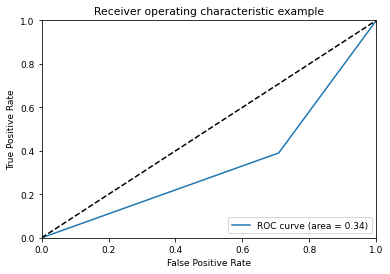

In [ ]:
import sklearn.metrics as metrics
##from sklearn.metrics import roc_curve, auc#, plot_roc_curve
#false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(testY, y_pred)
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(testY, y_pred)

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print("ROC AUC: ", roc_auc)


import pylab as pl
# Plot ROC curve
#pl.clf()
pl.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic example')
pl.legend(loc="lower right")
pl.show()

# Keras NN Dense

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential(
    [
        Dense(5, activation="relu"),
        Dense(10, activation="relu"),
        Dense(15),
    ]
)  # No weights to be addded here

# Here we cannot check for weights
# model.weights

# Neither we can look at the summary
# model.summary()

# First we must call the model and evaluate it on test data
x = tf.ones((5, 20))
y = model(x)
print("Number of weights after calling the model:", len(model.weights))

Number of weights after calling the model: 6


In [ ]:
from tensorflow import keras

model = keras.models.Sequential([
    keras.Input(shape = (14, )),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dense(1, activation = 'relu')
])

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint

model_path = dataPath01+'/models/'
model_name = 'dense_layers.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path + model_name,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

epochs = 60

model.fit(x=trainX,
          y=trainY,
          #batch_size=10,
          epochs=epochs,  #35 puede ser suficiente en este caso
          verbose=2,
          #callbacks=[model_checkpoint_callback]
          )

Epoch 1/60
9/9 - 0s - loss: nan - accuracy: 0.4942 - 32ms/epoch - 4ms/step
Epoch 2/60
9/9 - 0s - loss: nan - accuracy: 0.4942 - 31ms/epoch - 3ms/step
Epoch 3/60
9/9 - 0s - loss: nan - accuracy: 0.4942 - 34ms/epoch - 4ms/step
Epoch 4/60
9/9 - 0s - loss: nan - accuracy: 0.4942 - 30ms/epoch - 3ms/step
Epoch 5/60
9/9 - 0s - loss: nan - accuracy: 0.4942 - 44ms/epoch - 5ms/step
Epoch 6/60
9/9 - 0s - loss: nan - accuracy: 0.4942 - 30ms/epoch - 3ms/step
Epoch 7/60
9/9 - 0s - loss: nan - accuracy: 0.4942 - 23ms/epoch - 3ms/step
Epoch 8/60
9/9 - 0s - loss: nan - accuracy: 0.4942 - 33ms/epoch - 4ms/step
Epoch 9/60
9/9 - 0s - loss: nan - accuracy: 0.4942 - 28ms/epoch - 3ms/step
Epoch 10/60
9/9 - 0s - loss: nan - accuracy: 0.4942 - 34ms/epoch - 4ms/step
Epoch 11/60
9/9 - 0s - loss: nan - accuracy: 0.4942 - 29ms/epoch - 3ms/step
Epoch 12/60
9/9 - 0s - loss: nan - accuracy: 0.4942 - 27ms/epoch - 3ms/step
Epoch 13/60
9/9 - 0s - loss: nan - accuracy: 0.4942 - 50ms/epoch - 6ms/step
Epoch 14/60
9/9 - 0s 

# SVM

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')  #kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
svclassifier.fit(trainX, trainY)

#y_pred = svclassifier.predict(testX)

from sklearn.metrics import classification_report, confusion_matrix
print(svclassifier.score(testX, testY))
#print(confusion_matrix(y_pred,testY))
print(confusion_matrix(svclassifier.predict(testX), testY))
#print(classification_report(testY,y_pred))

y_pred = svclassifier.predict(testX)

0.4461538461538462
[[15 27]
 [ 9 14]]


## Save SVM model

In [ ]:
model_path = dataPath01+'/models/'
model_name = 'svm_hists_texts_07076.sav'

# save:
#joblib.dump(svclassifier, model_path + model_name)

# load:
loaded_model = joblib.load(model_path + model_name)
score = loaded_model.score(testX, testY)
print(score)
print(confusion_matrix(loaded_model.predict(testX), testY))

y_pred = svclassifier.predict(testX)

0.5692307692307692
[[11 15]
 [13 26]]


ROC AUC:  0.6347402597402597


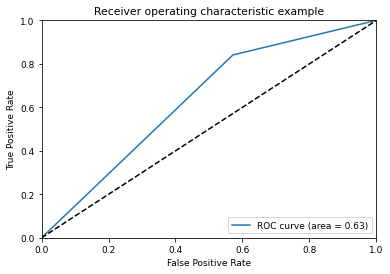

In [ ]:
import sklearn.metrics as metrics
##from sklearn.metrics import roc_curve, auc#, plot_roc_curve
#false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(testY, y_pred)
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(testY, y_pred)

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print("ROC AUC: ", roc_auc)


import pylab as pl
# Plot ROC curve
#pl.clf()
pl.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic example')
pl.legend(loc="lower right")
pl.show()

# PCA to display the data

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# features = list(range(0,250))
# features.extend(list(range(nbinxchanel * 2, nbinxchanel )))
# Separating out the features
#x = stats_df.loc[:, features].values
# Separating out the target
#y = stats_df.loc[:,['SEVERITY']].values
# Standardizing the features
#x = StandardScaler().fit_transform(x)

pca = PCA(n_components = 10)
principalComponents = pca.fit_transform(trainX)

principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
display(principalDf)

trainY_df = pd.DataFrame(trainY, columns = ['SEVERITY'])
display(trainY_df)


pca = PCA(n_components = 10)
principalComponents = pca.fit_transform(testX)

principalDf_test = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
display(principalDf_test)

testY_df = pd.DataFrame(testY, columns = ['SEVERITY'])
display(testY_df)


#finalDf = pd.concat([principalDf, trainY_df], axis = 1)
#display(finalDf)

#fig = plt.figure(figsize = (8,8))
#ax = fig.add_subplot(1,1,1)
#ax.set_xlabel('Principal Component 1', fontsize = 15)
#ax.set_ylabel('Principal Component 2', fontsize = 15)
#ax.set_title('2 component PCA', fontsize = 20)
#targets = ['Abnormal', 'Normal']
#colors = ['r', 'g']
#dims = ['PC1', 'PC2']

#for target, color in zip(targets,colors):
#    indicesToKeep = finalDf['SEVERITY'] == target
#    ax.scatter(finalDf.loc[indicesToKeep, dims[0]]
#               , finalDf.loc[indicesToKeep, dims[1]]
#               , c = color
#               , s = 50)
#ax.legend(targets)
#ax.grid()

#pcx = finalDf.loc[:, dims[0]]
#pcy = finalDf.loc[:, dims[1]]

#for i, txt in enumerate(range(0, (pcx.shape)[0])):
#    ax.annotate(txt, (pcx[i], pcy[i]))


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.250986,0.438070,-0.134096,0.089778,-0.014175,0.046915,0.010474,-0.000360,0.002910,0.000584
1,-0.134316,-0.170532,-0.145198,0.051057,-0.026861,-0.003508,0.033053,-0.002981,-0.004579,-0.003167
2,-0.259036,-0.041525,0.094192,0.026542,0.057895,-0.041388,-0.009367,-0.008321,0.002247,-0.001056
3,0.038933,-0.216997,-0.082607,0.077595,-0.011794,-0.031893,0.030940,0.004721,0.007215,-0.001311
4,-0.451708,-0.218340,0.108970,-0.092249,-0.014268,-0.003735,0.022143,0.007107,-0.006099,-0.004704
...,...,...,...,...,...,...,...,...,...,...
325,0.119980,-0.143185,-0.013210,-0.057256,0.020301,-0.043499,-0.008032,-0.005441,-0.002876,0.010101
326,-0.344114,-0.011398,0.032152,0.135288,0.044310,-0.076588,-0.019052,0.002583,0.005186,0.007135
327,1.042787,0.077502,0.070896,-0.017354,0.070140,0.002328,-0.018403,0.016038,-0.009142,-0.000396
328,0.690688,0.386171,0.120603,-0.066861,-0.012771,-0.035886,-0.016734,0.008254,0.007520,-0.005957


,SEVERITY
0,0
1,1
2,0
3,0
4,1
...,...
325,0
326,0
327,0
328,0


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.343049,-0.203646,-0.186785,0.057877,0.000086,-0.001987,-0.010707,0.029272,-0.000378,-0.002029
1,-0.516415,-0.099887,-0.049868,0.067589,0.048676,-0.047331,-0.007086,0.016624,-0.006014,0.000482
2,-0.370040,0.039038,0.098125,-0.263178,-0.013698,0.016447,0.018464,0.004804,-0.008070,-0.001324
3,-0.489031,-0.091497,0.001368,-0.021557,0.018537,-0.030696,-0.005260,0.015734,-0.006712,0.000783
4,0.329128,0.047348,0.062008,-0.149936,-0.055969,-0.023685,-0.015089,0.004371,-0.001570,0.004190
...,...,...,...,...,...,...,...,...,...,...
60,-0.147652,-0.202109,0.137819,0.070160,0.003057,0.029585,0.006094,-0.018596,-0.012227,0.009860
61,0.008211,0.548497,0.062951,-0.233101,-0.088873,0.064084,0.002532,0.000740,-0.005280,-0.002093
62,-0.363821,0.179868,0.064210,-0.173691,-0.015062,0.001954,0.025321,0.005246,0.000957,-0.002358
63,0.306697,0.204536,-0.098538,0.051467,0.030589,0.032383,0.017404,0.006583,-0.000523,0.004219


,SEVERITY
225,0
65,1
213,1
223,1
25,1
...,...
321,1
59,1
233,1
27,0


In [ ]:
# NN is sensitive to data scale, so we must normalize
#scaler = StandardScaler()
#scaler = MinMaxScaler()
#trainXX = trainX.copy()
#testXX = testX.copy()
# Don't cheat - fit only on training data
#scaler.fit(trainX)
#trainX = scaler.transform(trainX)
# apply same transformation to test data
#testX = scaler.transform(testX)
model = MLPClassifier(solver='lbfgs', alpha=0.001, activation = 'logistic', max_iter=2000,
                     hidden_layer_sizes = (5, 2), verbose = True, learning_rate = 'adaptive') #hid_lay: (4, 10) (7,10)

#model = MLPClassifier(solver='lbfgs', alpha=1e-5,
#                     hidden_layer_sizes=(5, 2), random_state=1, max_iter=7000)

#solver='lbfgs' 'sgd' 'adam'
model.fit(principalDf, trainY_df)

#Print the score on the train data
print("On training")
print(model.score(principalDf, trainY_df))
print(confusion_matrix(model.predict(principalDf), trainY_df))

#Print the score on the test data
print("\nOn test")
print(model.score(principalDf_test, testY_df))
print(confusion_matrix(model.predict(principalDf_test), testY_df))

y_pred = model.predict(principalDf_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


On training
0.5636363636363636
[[164 143]
 [  1  22]]

On test
0.3076923076923077
[[18 42]
 [ 3  2]]
